In [109]:
import os
import cv2
import keras
import warnings
import time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from keras.models import Sequential
from joblib import dump
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

warnings.filterwarnings('ignore')

## Each model takes about 15 minutes or less to train on my computer, therefore I think there is no need to modify anything, if need, modify cell below to change img_size = 64 to img_size = 32 to reduce image size by half. Also look at (A) comment for further data reduction

## Load image

### Dog breed image dataset

In [110]:
# Labels for image categories
labels = ['Beagle', 'Boxer', 'Bulldog', 'Dachshund', 'German_Shepherd', 'Golden_Retriever', 'Labrador_Retriever', 'Poodle', 'Rottweiler', 'Yorkshire_Terrier']
img_size = 64

def loading_training_data(data_dir):
    data = []
    labels_list = []
    
    for label in labels:
        # path = os.path.join(data_dir, label)
        path = data_dir+"/"+label
        class_num = labels.index(label)
        for img in os.listdir(path):
            # print(img)
            # print(path)
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            
            # print(os.path.join(path,img))
            if img_arr is None:
                # print(f"Warning: Unable to load image {img}")
                print(os.path.join(path,img))
                continue  # Skip the image if it can't be loaded
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append(resized_arr)
            labels_list.append(class_num)
            
    return np.array(data), np.array(labels_list)

# Load data for training, testing, and validation
# train_data1, train_labels1 = loading_training_data('./archive/chest_xray/chest_xray/train/')
dog_breed_train_data, dog_breed_train_label = loading_training_data('./DogBreedImageDataset/dataset')

In [111]:
def loading_training_data2(data_dir, img_size=64):
    data = []
    labels_list = []
    labels = os.listdir(data_dir)  # Get the list of class labels (folders)

    for label in labels:
        # path = data_dir+"\\"+label
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        images = os.listdir(path)

        # Calculate the number of images to keep
        num_images_to_keep = len(images) // 8

        # Randomly select 50% of the images from each class
        selected_images = random.sample(images, num_images_to_keep)

        for img in selected_images:
             img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
             if img_arr is None:
                # print(f"Warning: Unable to load image {img}")
                print(os.path.join(path, img))
                continue  # Skip the image if it can't be loaded
             resized_arr = cv2.resize(img_arr, (img_size, img_size))
             data.append(resized_arr)
             labels_list.append(class_num)
            
    return np.array(data), np.array(labels_list)

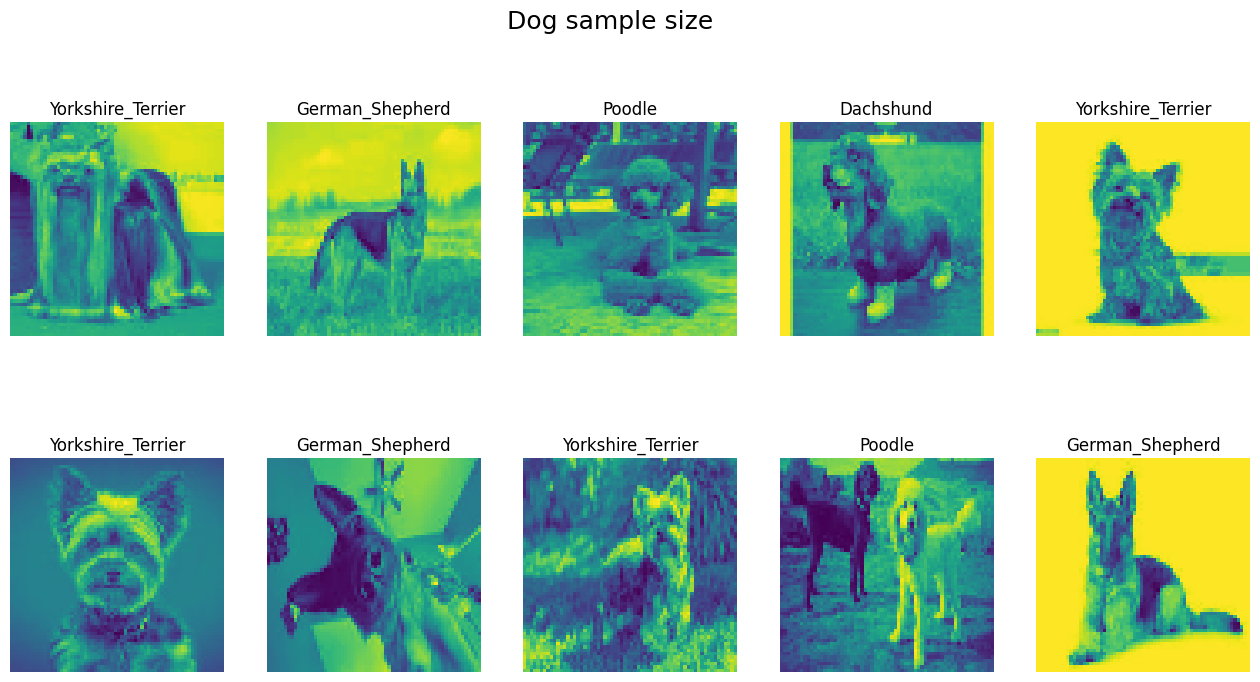

In [112]:
random_indices = np.random.choice(len(dog_breed_train_data), 10, replace=False)
plt.figure(figsize=(16, 8))

for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1) 
    plt.imshow(dog_breed_train_data[idx].astype(np.uint8), cmap='viridis')
    plt.title(labels[dog_breed_train_label[idx]])
    plt.axis('off') 

plt.suptitle("Dog sample size", size=18)
plt.show()

### Pet Facial Expression Dataset

In [113]:
labels = ['Angry', 'happy', 'Other', 'Sad']
# Load data for training, testing, and validation
pet_facial_train_data, pet_facial_train_label = loading_training_data('./PetFacialExpressionDataset/Master_Folder/train/')
pet_facial_test_data, pet_facial_test_label = loading_training_data('./PetFacialExpressionDataset/Master_Folder/train/')
pet_facial_val_data, pet_facial_val_label = loading_training_data('./PetFacialExpressionDataset/Master_Folder/train/')

In [114]:
pet_facial_train_data.shape

(1000, 64, 64)

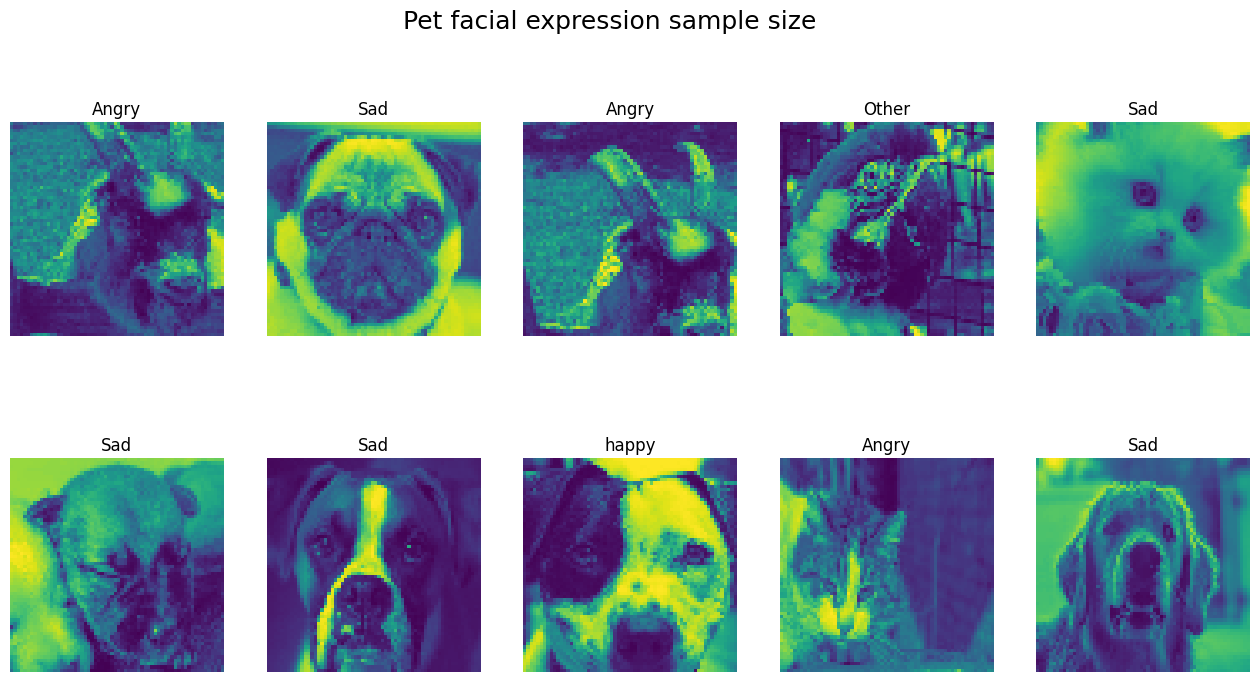

In [115]:
random_indices = np.random.choice(len(pet_facial_train_data), 10, replace=False)
plt.figure(figsize=(16, 8))

for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1) 
    plt.imshow(pet_facial_train_data[idx].astype(np.uint8), cmap='viridis')
    plt.title(labels[pet_facial_train_label[idx]])
    plt.axis('off') 

plt.suptitle("Pet facial expression sample size", size=18)
plt.show()

### Dog Emotion Prediction

In [116]:
labels = ['angry', 'happy', 'relaxed', 'sad']
# Load data for training, testing, and validation
dog_emotion_train_data, dog_emotion_train_label = loading_training_data('./DogEmotionPrediction/images/')

In [117]:
dog_emotion_train_data.shape[0]

15921

In [118]:
type(dog_emotion_train_data)

numpy.ndarray

In [119]:
# Calculate the number of images to keep
num_images_to_keep = dog_emotion_train_data.shape[0] // 8

indices = np.random.choice(dog_emotion_train_data.shape[0], num_images_to_keep, replace=False)
# Randomly select 50% of the images from each class
dog_emotion_train_data = dog_emotion_train_data[indices]
dog_emotion_train_label = dog_emotion_train_label[indices]

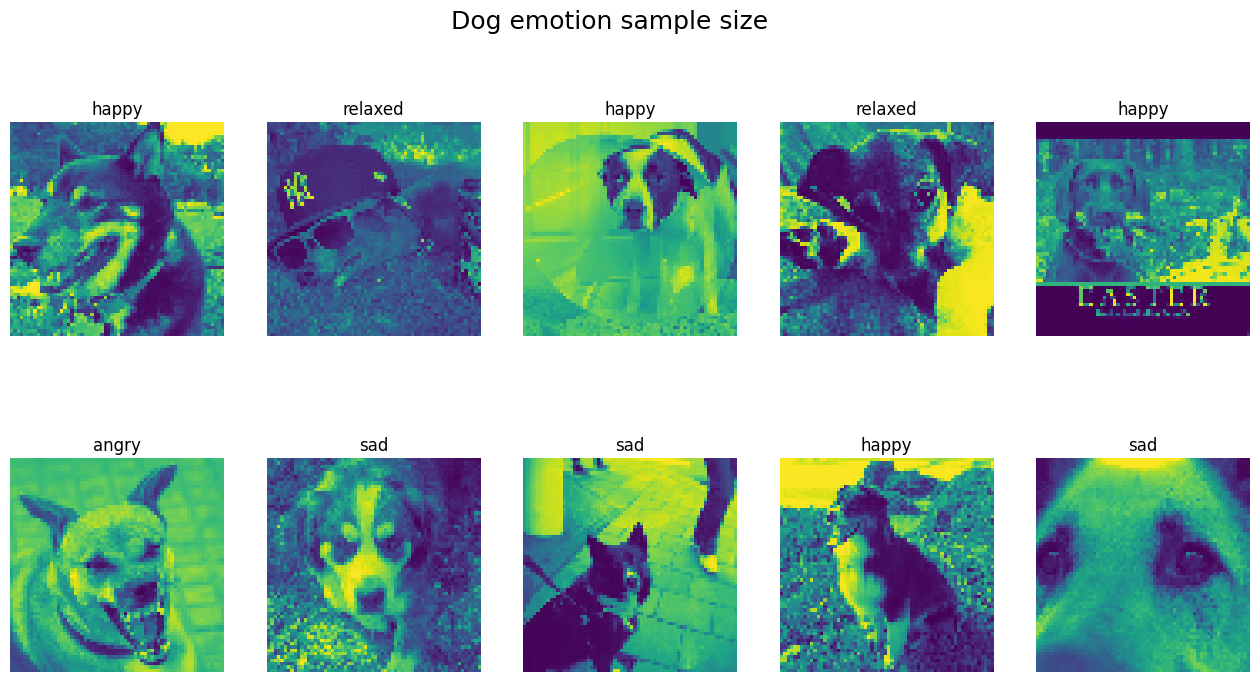

In [120]:
random_indices = np.random.choice(len(dog_emotion_train_data), 10, replace=False)
plt.figure(figsize=(16, 8))

for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1) 
    plt.imshow(dog_emotion_train_data[idx].astype(np.uint8), cmap='viridis')
    plt.title(labels[dog_emotion_train_label[idx]])
    plt.axis('off') 

plt.suptitle("Dog emotion sample size", size=18)
plt.show()

## Train test split dataset

In [121]:
from sklearn.model_selection import train_test_split 

In [122]:
X_dbreed_train, _, y_dbreed_train, _= train_test_split(
    dog_breed_train_data, dog_breed_train_label, test_size=0.5, random_state=42)

In [123]:
dog_breed_train_data.shape

(967, 64, 64)

In [124]:
X_dbreed_train, X_dbreed_test, y_dbreed_train, y_dbreed_test= train_test_split(
    X_dbreed_train, y_dbreed_train, test_size=0.5, random_state=42)

## Train on dog breed dataset

https://www.geeksforgeeks.org/image-classification-using-support-vector-machine-svm-in-python/

In [125]:
from sklearn import svm 
from sklearn.model_selection import GridSearchCV 

In [126]:
# Defining the parameters grid for GridSearchCV 
param_grid={'C':[0.1,1,10]} 
  
# Creating a support vector classifier 
svc=svm.SVC(probability=True, verbose=True, kernel = 'linear') 
  
# Creating a model using GridSearchCV with the parameters grid 
model=GridSearchCV(svc,param_grid)

In [127]:
# Reshape the images to be 2D, where each image is flattened into a 1D vector
X_dbreed_train_flat = X_dbreed_train.reshape(X_dbreed_train.shape[0], -1) 

In [128]:
start_time = time.time()

In [129]:
model.fit(X_dbreed_train_flat, y_dbreed_train)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

GridSearchCV(estimator=SVC(kernel='linear', probability=True, verbose=True),
             param_grid={'C': [0.1, 1, 10]})

In [130]:
dump(model, 'svm_dog_breed.joblib')

['svm_dog_breed.joblib']

In [131]:
end_time = time.time()

In [132]:
duration = end_time - start_time
print("Time to train is " + str(duration) + " seconds")

Time to train is 5.724358797073364 seconds


Best params after training the model is 

In [133]:
model.best_params_

{'C': 0.1}

In [134]:
# Testing the model using the testing data 
y_pred = model.predict(X_dbreed_test.reshape(X_dbreed_test.shape[0], -1)) 

from sklearn.metrics import accuracy_score 
# Calculating the accuracy of the model 
accuracy = accuracy_score(y_pred, y_dbreed_test) 

In [27]:
print(accuracy)

0.7479338842975206


The model has 75% accuracy

In [28]:
X_dbreed_test[0].reshape(-1).shape

(4096,)

Sample prediction

In [29]:
y_pred1 = model.predict(X_dbreed_test[0].reshape(1,-1))
y_pred1

array([2])

In [30]:
y_dbreed_test[0]

2

In [31]:
def plotImg(image, label, title):
    plt.imshow(image.astype(np.uint8), cmap='viridis')
    plt.title(label)
    plt.axis('off') 
    
    plt.suptitle(title, size=10)
    plt.show()

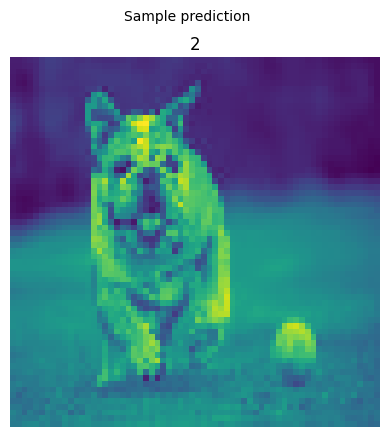

In [32]:
plotImg(X_dbreed_test[0], y_dbreed_test[0], "Sample prediction")

https://www.geeksforgeeks.org/multi-class-classification-using-support-vector-machines-svm/

## Train on handling emotion prediction

In [33]:
np.unique(pet_facial_train_label, return_counts=True)

(array([0, 1, 2, 3]), array([250, 250, 250, 250], dtype=int64))

In [34]:
labels = ['Angry', 'happy', 'Other', 'Sad']

In [35]:
np.unique(dog_emotion_train_label, return_counts=True)

(array([0, 1, 2, 3]), array([279, 619, 514, 578], dtype=int64))

In [36]:
labels = ['angry', 'happy', 'relaxed', 'sad']

As we can see in dog emotion label, it has relaxed instead of other, we will change dog_emotion_train_label of relaxed (2) to 4

In [37]:
dog_emotion_train_label[dog_emotion_train_label == 2] = 4

In [38]:
np.unique(dog_emotion_train_label, return_counts=True)

(array([0, 1, 3, 4]), array([279, 619, 578, 514], dtype=int64))

In [39]:
# Defining the parameters grid for GridSearchCV 
# param_grid={'C':[0.1,1,10], 
#             'gamma':[0.0001,0.001,0.1]} 

param_grid={'C':[0.1,1,10]} 
  
# Creating a support vector classifier 
svc=svm.SVC(probability=True, verbose=True, kernel = 'linear') 
  
# Creating a model using GridSearchCV with the parameters grid 
model=GridSearchCV(svc,param_grid)

In [40]:
# Reshape the images to be 2D, where each image is flattened into a 1D vector
pet_facial_train_data_flat = pet_facial_train_data.reshape(pet_facial_train_data.shape[0], -1) 

In [41]:
start_time = time.time()

In [42]:
model.fit(pet_facial_train_data_flat, pet_facial_train_label)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

GridSearchCV(estimator=SVC(kernel='linear', probability=True, verbose=True),
             param_grid={'C': [0.1, 1, 10]})

In [44]:
dump(model, './svm_linear/svm_pet_facial.joblib')

['./svm_linear/svm_pet_facial.joblib']

In [45]:
end_time = time.time()

In [46]:
duration = end_time - start_time
print("Time to train is " + str(duration) + " seconds")

Time to train is 10509.928062915802 seconds


In [47]:
model.best_params_

{'C': 0.1}

In [48]:
accuracy = accuracy_score(model.predict(pet_facial_test_data.reshape(pet_facial_test_data.shape[0], -1)), pet_facial_test_label) 

In [49]:
accuracy

1.0

We got 100 percent prediction correct

In [50]:
model.predict(pet_facial_val_data[0].reshape(1,-1))

array([0])

## Train on dog emotion detection

In [51]:
# Reshape the images to be 2D, where each image is flattened into a 1D vector
dog_emotion_train_data_flat = dog_emotion_train_data.reshape(dog_emotion_train_data.shape[0], -1) 

In [52]:
dog_emotion_train_data_flat.shape

(1990, 4096)

In [53]:
Xdog_emotion_train_data_flat, Xdog_emotion_test_data_flat, ydog_emotion_train_label, ydog_emotion_test_label= train_test_split(
    dog_emotion_train_data_flat, dog_emotion_train_label, test_size=0.3, random_state=42)

In [54]:
sample_size = len(dog_emotion_train_data_flat)

In [55]:
random_indices_train = np.random.choice(sample_size, size=int(sample_size/2), replace=False)

In [56]:
dog_emotion_train_data_flat1 = dog_emotion_train_data_flat[random_indices_train]

In [57]:
dog_emotion_train_label1 = dog_emotion_train_label[random_indices_train]

In [58]:
Xdog_emotion_train_data_flat1, Xdog_emotion_test_data_flat1, ydog_emotion_train_label1, ydog_emotion_test_label1= train_test_split(
    dog_emotion_train_data_flat1, dog_emotion_train_label1, test_size=0.3, random_state=42)

In [59]:
# Defining the parameters grid for GridSearchCV 
param_grid={'C':[0.1,1,10]} 
  
# Creating a support vector classifier 
svc=svm.SVC(probability=True, verbose=True, kernel = 'linear') 
  
# Creating a model using GridSearchCV with the parameters grid 
model=GridSearchCV(svc,param_grid)

In [60]:
start_time = time.time()

In [61]:
 model.fit(Xdog_emotion_train_data_flat1, ydog_emotion_train_label1)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

GridSearchCV(estimator=SVC(kernel='linear', probability=True, verbose=True),
             param_grid={'C': [0.1, 1, 10]})

In [62]:
dump(model, './svm_linear/svm_dog_facial.joblib')

['./svm_linear/svm_dog_facial.joblib']

In [63]:
end_time = time.time()

In [64]:
duration = end_time - start_time
print("Time to train is " + str(duration) + " seconds")

Time to train is 45.9769983291626 seconds


In [65]:
model.best_params_

{'C': 0.1}

In [66]:
accuracy = accuracy_score(model.predict(Xdog_emotion_test_data_flat1), ydog_emotion_test_label1) 

In [67]:
accuracy

0.28762541806020064

## Combine two dataset (2 emotion dataset)

In [68]:
pet_facial_train_data_flat.shape

(1000, 4096)

In [69]:
Xdog_emotion_train_data_flat.shape

(1393, 4096)

In [70]:
new_train_data =  np.concatenate((pet_facial_train_data_flat, Xdog_emotion_train_data_flat), axis=0)

In [71]:
new_train_label = np.concatenate((pet_facial_train_label, ydog_emotion_train_label), axis = 0)

In [72]:
len(new_train_label)

2393

In [73]:
random_indices = np.random.choice(len(new_train_label), size=int(len(new_train_label)/2), replace=False)

## (A) Uncomment line below to slash dataset by half to reduce training time

In [74]:
# new_train_data=new_train_data[random_indices]
# new_train_label = new_train_label[random_indices]

In [75]:
new_train_label.shape

(2393,)

In [76]:
# Defining the parameters grid for GridSearchCV 
param_grid={'C':[0.1,1,10]} 
  
# Creating a support vector classifier 
svc=svm.SVC(probability=True, verbose=True, kernel = 'linear') 
  
# Creating a model using GridSearchCV with the parameters grid 
model=GridSearchCV(svc,param_grid)

In [77]:
start_time = time.time()

In [78]:
 model.fit(new_train_data, new_train_label)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

GridSearchCV(estimator=SVC(kernel='linear', probability=True, verbose=True),
             param_grid={'C': [0.1, 1, 10]})

In [79]:
dump(model, './svm_linear/svm_combine_facial.joblib')

['./svm_linear/svm_combine_facial.joblib']

In [80]:
end_time = time.time()

In [81]:
duration = end_time - start_time
print("Time to train is " + str(duration) + " seconds")

Time to train is 962.4515907764435 seconds


In [82]:
model.best_params_

{'C': 0.1}

In [83]:
 accuracy = accuracy_score(model.predict(pet_facial_val_data.reshape(pet_facial_val_data.shape[0], -1)), pet_facial_test_label) 

In [84]:
accuracy

1.0

In [85]:
accuracy = accuracy_score(model.predict(Xdog_emotion_test_data_flat1), ydog_emotion_test_label1) 

In [86]:
accuracy

0.7725752508361204

Combining dataset improve performance on prediction of dog dataset while reduce accuracy of pet dataset. Dog dataset also includes humans and different angles, hence why the low prediction

## Combine all dataset

In [87]:
new_train_data.shape

(2393, 4096)

In [88]:
np.unique(new_train_label,return_counts = True)

(array([0, 1, 2, 3, 4]), array([440, 686, 250, 644, 373], dtype=int64))

In [89]:
X_dbreed_train.shape

(241, 64, 64)

Need to change dbreed label to increase in number to combine dataset

In [90]:
np.unique(y_dbreed_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([19, 19, 26, 19, 25, 22, 19, 33, 27, 32], dtype=int64))

In [91]:
y_dbreed_train += 5

In [92]:
np.unique(y_dbreed_train, return_counts=True)

(array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([19, 19, 26, 19, 25, 22, 19, 33, 27, 32], dtype=int64))

In [93]:
all_train_data=  np.concatenate((new_train_data, Xdog_emotion_train_data_flat), axis=0)

In [94]:
all_train_label = np.concatenate((new_train_label, y_dbreed_train), axis = 0)

In [95]:
# Defining the parameters grid for GridSearchCV 
param_grid={'C':[0.1,1,10]} 
  
# Creating a support vector classifier 
svc=svm.SVC(probability=True, verbose=True, kernel = 'linear') 
  
# Creating a model using GridSearchCV with the parameters grid 
model=GridSearchCV(svc,param_grid)

In [96]:
start_time = time.time()

In [97]:
model.fit(new_train_data, new_train_label)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

GridSearchCV(estimator=SVC(kernel='linear', probability=True, verbose=True),
             param_grid={'C': [0.1, 1, 10]})

In [98]:
dump(model, './svm_linear/svm_all_data.joblib')

['./svm_linear/svm_all_data.joblib']

In [99]:
end_time = time.time()

In [100]:
duration = end_time - start_time
print("Time to train is " + str(duration) + " seconds")

Time to train is 893.525759935379 seconds


In [101]:
model.best_params_

{'C': 0.1}

In [102]:
accuracy = accuracy_score(y_pred, y_dbreed_test) 

In [103]:
# Testing the model using the testing data 
y_pred = model.predict(X_dbreed_test.reshape(X_dbreed_test.shape[0], -1)) 

# Calculating the accuracy of the model 
accuracy = accuracy_score(y_pred, y_dbreed_test) 

In [104]:
accuracy

0.1652892561983471

In [105]:
 accuracy = accuracy_score(model.predict(pet_facial_val_data.reshape(pet_facial_val_data.shape[0], -1)), pet_facial_test_label) 

In [106]:
accuracy

1.0

In [107]:
accuracy = accuracy_score(model.predict(Xdog_emotion_test_data_flat1), ydog_emotion_test_label1) 

In [108]:
accuracy

0.7725752508361204